
# Imports

In [2]:
########################## EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

########################## Preprecessing
#import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

# Read data

In [3]:
# Reading the CSV File 
df = pd.read_csv("imdb.csv")
# Taking 80% of the samples from the data for training
df_train = df.sample(frac = 0.8)
# Remaining 20% for testing
df_valid = df.drop(df_train.index)
print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 20000
Number of documents in validation data: 5000


In [5]:
# Cleaning the unwanted noise such as numbers, symbols and punctuations
def clean_data(df):
    df_original = df.copy()
    for index in range(len(df.review.values)):
        my_str = df.review.values[index]
        clean_text = ''.join([str(char) for char in my_str if char.isalpha() or char.isspace()])
        df.iloc[index,0] = clean_text.lower()
    return df, df_original

In [6]:
# Storing cleaned and the original ones
df_train_cleaned, df_train = clean_data(df_train)

In [9]:
# Storing cleaned and the original ones
df_valid_cleaned, df_valid = clean_data(df_valid)

# EDA
### Target

In [10]:
# Unique Values are 0-1 (Binary)
df_train_cleaned.groupby(['sentiment']).count()

,review
sentiment,
0,9964
1,10036


<AxesSubplot:xlabel='sentiment', ylabel='count'>

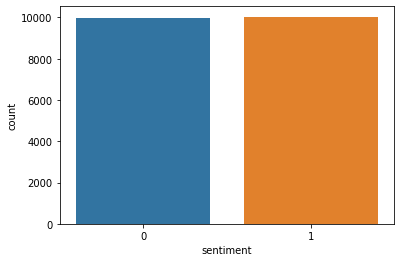

In [11]:
# From the countplot we can see that the target sentiment has almost the equal number of 0's and 1's
sns.countplot(x="sentiment", data=df_train_cleaned)

### Text

In [12]:
# Filtering out the positive & negative reviews and storing the reviewed text seperately 
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

Wall time: 19.3 s


Text(0.5, 1.0, 'Negative')

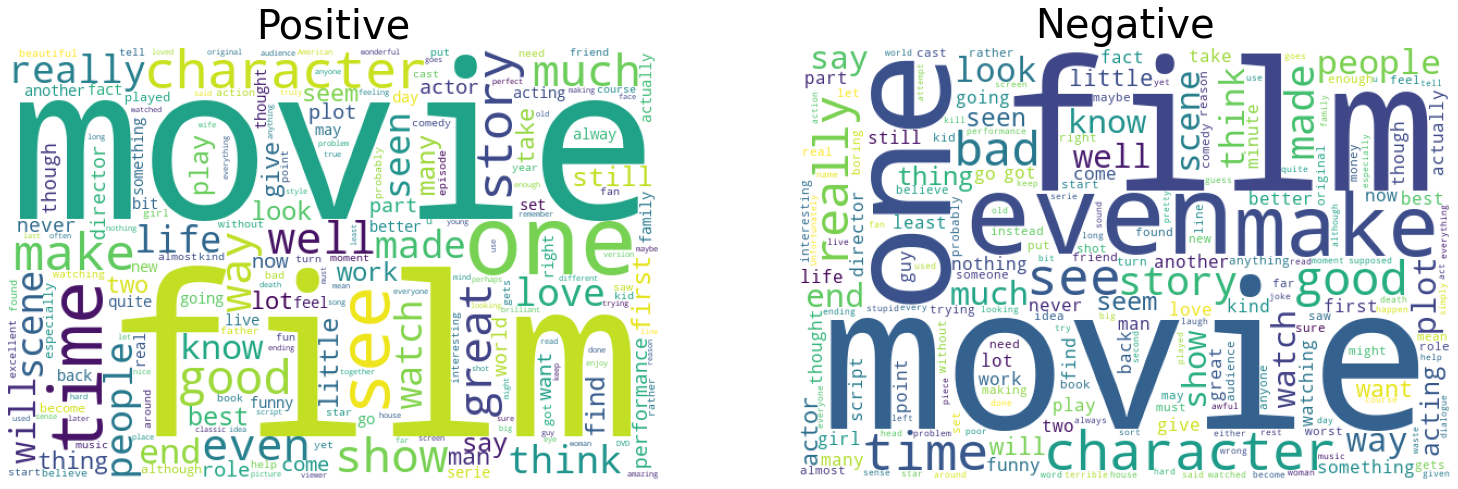

In [13]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [14]:
texts = [
    'Hello this is an sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [15]:
# create a CountVectorizer instance
bow = CountVectorizer()
# fit tranform the text with it
texts_bow = bow.fit_transform(texts)
# get the features+ (words)
tokens = bow.get_feature_names_out()
# Representing the texts_bow to np array with the index that corresponds the lines and column names as the tokens
pd.DataFrame(data=texts_bow.toarray(), index=['First Text', 'Second Text', "Third Text"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
First Text,1,0,1,1,0,1,1
Second Text,0,1,1,1,0,1,1
Third Text,0,0,3,1,1,0,1


### Bag Of Words (BOW) + ngram

In [16]:
#do the same approach but using a range in the count vectorizer
# create a CountVectorizer instance
# Ngram - Unigram (1,1), Unigram & Bigram (1,2), Bigram (2,2)
bow = CountVectorizer(ngram_range=(2,2))
# fit tranform the text with it
texts_bow = bow.fit_transform(texts)
# get the features+ (words)
tokens = bow.get_feature_names_out()
# Representing the texts_bow to np array with the index that corresponds the lines and column names as the tokens
pd.DataFrame(data=texts_bow.toarray(), index=['First Text', 'Second Text', "Third Text"], columns=tokens)

,an sentence,another sentence,hello hello,hello this,is an,is another,is mellow,this is
First Text,1,0,0,1,1,0,0,1
Second Text,0,1,0,1,0,1,0,1
Third Text,0,0,2,1,0,0,1,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [17]:
#Same approach for the TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True) #When True it calculates the score of the frequency of the word, when False calculates
# how rare the word is in the text
# fit tranform the text with it
texts_tfidf = tfidf.fit_transform(texts)
# get the features+ (words)
tokens = tfidf.get_feature_names_out()
# Representing the texts_tfidf to np array with the index that corresponds the lines and column names as the tokens
pd.DataFrame(data=texts_tfidf.toarray(), index=['First Text', 'Second Text', "Third Text"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
First Text,0.617227,0.000000,0.364544,0.364544,0.000000,0.469417,0.364544
Second Text,0.000000,0.617227,0.364544,0.364544,0.000000,0.469417,0.364544
Third Text,0.000000,0.000000,0.805627,0.268542,0.454682,0.000000,0.268542


# <center> Apply to the reviews

### Bag Of Words 1-gram

In [28]:
%%time
# Min_df i.e the terms in less than 3 documents will be ignored
# max_df i.e the terms that appears in more than 70% documents will be ignored
bow_1gram = CountVectorizer(ngram_range=(1,1), min_df=3, max_df=0.7)
train_bow_1gram = bow_1gram.fit_transform(df_train_cleaned["review"])
valid_bow_1gram = bow_1gram.transform(df_valid_cleaned["review"])

Wall time: 4.27 s


### Bag Of Words 1-2-grams

In [29]:
%%time
# Min_df i.e the terms in less than 3 documents will be ignored
# max_df i.e the terms that appears in more than 70% documents will be ignored
bow_2grams = CountVectorizer(ngram_range=(1,2), min_df=3, max_df=0.7)
train_bow_2grams = bow_2grams.fit_transform(df_train_cleaned["review"])
valid_bow_2grams = bow_2grams.transform(df_valid_cleaned["review"])

Wall time: 11.2 s


### TFIDF 1-gram

In [30]:
%%time
# Min_df i.e the terms in less than 3 documents will be ignored
# max_df i.e the terms that appears in more than 70% documents will be ignored
tfidf_1gram = TfidfVectorizer(ngram_range=(1,1), min_df=3, max_df=0.7)
train_tfidf_1gram = tfidf_1gram.fit_transform(df_train_cleaned["review"])
valid_tfidf_1gram = tfidf_1gram.transform(df_valid_cleaned["review"])

Wall time: 4.53 s


### TFIDF 1-2-grams

In [31]:
%%time
# Min_df i.e the terms in less than 3 documents will be ignored
# max_df i.e the terms that appears in more than 70% documents will be ignored
tfidf_2grams = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.7)
train_tfidf_2grams = tfidf_2grams.fit_transform(df_train_cleaned['review'])
valid_tfidf_2grams = tfidf_2grams.transform(df_valid_cleaned['review'])

Wall time: 12.1 s


In [32]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (20000, 34501)
BOW 2grams   (20000, 218095)
TFIDF 1gram  (20000, 34501)
TFIDF 2grams (20000, 218095)


# <center> ML Models

## Naive Bayes (<1 s)

In [33]:
for name, x_train, x_valid in data:
    #Train a MultinomialNB model and meassure the time
    model = MultinomialNB()
    start_time = time.time()
    model.fit(x_train, df_train["sentiment"])
    pred = model.predict(x_valid)
    total_time = time.time() - start_time
    a = accuracy_score(df_valid["sentiment"], pred)
    print(name, "\tAccuracy:\t", a, "\tTime:\t", total_time)

BOW 1gram 	Accuracy:	 0.8504 	Time:	 0.02294015884399414
BOW 2grams 	Accuracy:	 0.8748 	Time:	 0.056847333908081055
TFIDF 1gram 	Accuracy:	 0.8638 	Time:	 0.01994800567626953
TFIDF 2grams 	Accuracy:	 0.8844 	Time:	 0.05285763740539551


## Logistic Regression (30s)

In [34]:
for name, x_train, x_valid in data:
    #Train a LogisticRegression model and meassure the time
    model = LogisticRegression(n_jobs=-1)
    start_time = time.time()
    model.fit(x_train, df_train["sentiment"])
    total_time = time.time() - start_time
    a = accuracy_score(df_valid["sentiment"], model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", total_time)

BOW 1gram 	Accuracy:	 0.8748 	Time:	 3.1380324363708496
BOW 2grams 	Accuracy:	 0.8938 	Time:	 6.657347917556763
TFIDF 1gram 	Accuracy:	 0.8844 	Time:	 2.155665397644043
TFIDF 2grams 	Accuracy:	 0.8872 	Time:	 5.065814971923828


## Random Forest (10+90+6+22 seconds)

In [35]:
for name, x_train, x_valid in data:
    #Train a RandomForestClassifier model and meassure the time
    model = RandomForestClassifier()
    start_time = time.time()
    model.fit(x_train, df_train["sentiment"])
    total_time = time.time() - start_time
    a = accuracy_score(df_valid["sentiment"], model.predict(x_valid))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", total_time)

BOW 1gram 	Accuracy:	 0.8438 	Time:	 45.05614638328552
BOW 2grams 	Accuracy:	 0.8498 	Time:	 81.0825366973877
TFIDF 1gram 	Accuracy:	 0.8374 	Time:	 40.61100745201111
TFIDF 2grams 	Accuracy:	 0.843 	Time:	 75.0070812702179
